# Proyecto ML: Modelo predictivo de precios de coche.

## 1. Introducción.

En este cuaderno buscaremos elaborar un modelo predictivo utilizando Machine Learning para saber una estimación del precio de un determinado vehículo de segunda mano y poder optimizar la compraventa de coches.

Por esto, el objetivo es tener una plataforma web donde poder saber el precio de un determinado vehículo de segunda mano, en base al precio de otros coches registrados en nuestra base de datos. Para ello, se utilizan los registros guardados en la tabla TX_VEHICULOS_SEG_MANO de nuestra BBDD de sqlite, con cerca de 35.000 registros de vehículos de 10 marcas diferentes importadas desde un Dataset de Kaggle hecho a partir de WebScraping, a los que hemos añadido X vehículos scrapeados mediante el script guardado en la ruta ```"dags/webscraping_script.py"``` de la página de [coches.net](coches.net).

Los registros obtenidos mediante ambos orígenes de datos han sido posibles de combinar mediante las transformaciones realizadas en el cuaderno ```"notebooks/kaggle_dataset_cleaning.ipynb"```, aunque antes de entrenar el modelo predictivo será necesario realizar algunas transformaciones adicionales, así como seleccionar las features del modelo.

En este proyecto, se utilizarán modelos de Machine Learning para calcular el precio de un coche a partir de características como la marca, modelo, tipo de combustible, año, etc. Se trata, por tanto, de un problema de regresión. Se utilizará como métrica de optimización el Mean Squared Error (MSE), aunque también se analizarán otras métricas como el Mean Average Error (MAE).

## 2. Obtención y procesado de datos.

Importamos los datos desde nuestra base de datos:

In [2]:
# Importamos las librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


sns.set_style("darkgrid")


colors = ["#d5001c", "#f59908", "#ffcb01", "#969696"]

In [3]:
import sqlite3

con = sqlite3.connect("../include/db_vehiculos.db")

query = """
SELECT *
FROM TX_VEHICULOS_SEG_MANO
--where
    --origen_anuncio = 'WebScraping'
    --origen_anuncio = 'dataset kaggle'
    --and marca not in ('BMW', 'VOLKSWAGEN', 'MERCEDES-BENZ', 'AUDI', 'PEUGEOT', 'FORD', 'RENAULT', 'OPEL', 'CITROEN', 'SEAT')
order by
    fecha_carga desc
;
"""

df = pd.read_sql_query(query, con)

df.head()

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60498281,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
1,59710104,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
2,60479478,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...
3,60374025,CITROEN,c3,16500.0,Gasolina,2022.0,18150,83.0,5.0,5.0,...,Berlina,1199.0,blanco,Madrid,None,WebScraping,2025-04-19,202504.0,2025-05-18 10:05:00,https://www.coches.net/citroen-c3-puretech-60k...
4,60576644,VOLKSWAGEN,california,67900.0,Diesel,2023.0,12000,150.0,4.0,4.0,...,Monovolumen,1968.0,Blanco,Las Palmas,None,WebScraping,2025-05-18,202505.0,2025-05-18 07:24:21,https://www.coches.net/volkswagen-california-o...


Podemos ver el número de registros para cada origen de datos:

In [4]:
df['origen_anuncio'].value_counts()

origen_anuncio
dataset kaggle    35041
WebScraping        1566
Name: count, dtype: int64

Vemos que la gran mayoría de registros provienen del dataset de kaggle.

Vamos a ver qué columnas contiene el DataFrame:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36607 entries, 0 to 36606
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        36607 non-null  int64  
 1   marca                36607 non-null  object 
 2   modelo               36607 non-null  object 
 3   precio               36607 non-null  float64
 4   combustible          36545 non-null  object 
 5   anyo_vehiculo        36606 non-null  float64
 6   kilometraje          36607 non-null  int64  
 7   potencia             29814 non-null  float64
 8   num_puertas          36595 non-null  float64
 9   num_plazas           1550 non-null   float64
 10  tipo_cambio          36527 non-null  object 
 11  tipo_vehiculo        1566 non-null   object 
 12  cilindrada_motor     1534 non-null   float64
 13  color                36128 non-null  object 
 14  provincia            36603 non-null  object 
 15  etiqueta_eco         1121 non-null  

Vemos que el DataFrame se compone de 21 columnas, de las cuales, muchas de ellas son de tipo string. Además, contienen valores nulos, por lo que, a continuación, haremos un procesado de estas columnas.

La columna target u objetivo a predecir es la columna llamada ```"price"```.

Lo primero que haremos es eliminar las columnas ```['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco']```, ya que solo tienen valores no nulos para los registros obtenidos mediante WebScraping.

In [6]:
df = df.drop(columns=['num_plazas', 'tipo_vehiculo', 'cilindrada_motor', 'etiqueta_eco'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36607 entries, 0 to 36606
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   pk_anuncio_id        36607 non-null  int64  
 1   marca                36607 non-null  object 
 2   modelo               36607 non-null  object 
 3   precio               36607 non-null  float64
 4   combustible          36545 non-null  object 
 5   anyo_vehiculo        36606 non-null  float64
 6   kilometraje          36607 non-null  int64  
 7   potencia             29814 non-null  float64
 8   num_puertas          36595 non-null  float64
 9   tipo_cambio          36527 non-null  object 
 10  color                36128 non-null  object 
 11  provincia            36603 non-null  object 
 12  origen_anuncio       36607 non-null  object 
 13  fecha_publicacion    36600 non-null  object 
 14  anyomes_publicacion  36600 non-null  float64
 15  fecha_carga          36607 non-null 

Vamos a eliminar también las columnas: ```['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url']```, ya que tampoco aportan información para el modelo.

De momento dejamos la columna ```'origen_anuncio'``` por si hay que distinguir en alguna transformación entre los datos de ambos orígenes.

In [7]:
df = df.drop(columns=['pk_anuncio_id', 'provincia', 'fecha_publicacion', 'anyomes_publicacion','fecha_carga', 'url'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36607 entries, 0 to 36606
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           36607 non-null  object 
 1   modelo          36607 non-null  object 
 2   precio          36607 non-null  float64
 3   combustible     36545 non-null  object 
 4   anyo_vehiculo   36606 non-null  float64
 5   kilometraje     36607 non-null  int64  
 6   potencia        29814 non-null  float64
 7   num_puertas     36595 non-null  float64
 8   tipo_cambio     36527 non-null  object 
 9   color           36128 non-null  object 
 10  origen_anuncio  36607 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 3.1+ MB


Vamos a analizar los nulos de la columna ```'potencia'```, a ver si son debidos al tipo de combustible o simplemente falta en esos registros.

In [8]:
df.groupby("combustible")["potencia"].apply(lambda x: x.isnull().sum())

combustible
Diesel                   3
Diésel                4883
Eléctrico                0
Gas licuado (GLP)        0
Gas natural (CNG)        0
Gasolina              1879
Híbrido                  0
Híbrido Enchufable       0
Híbrido enchufable       0
Name: potencia, dtype: int64

Como parece que hay varios formatos de la columna combustible, vamos a mapearlos:

In [9]:

mapa_combustible = {
    "Diesel": "Diésel",
    "Híbrido enchufable": "Híbrido Enchufable",
    "Híbrido Enchufable": "Híbrido Enchufable"
}

df["combustible"] = df["combustible"].replace(mapa_combustible)

In [10]:
df["combustible"].value_counts()

combustible
Diésel                24416
Gasolina              11179
Híbrido Enchufable      325
Eléctrico               306
Híbrido                 212
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

In [11]:
df[df["potencia"].isna()].groupby("combustible").size()

combustible
Diésel      4886
Gasolina    1879
dtype: int64

Observamos que todos los nulos son para vehículos de gasolina o diésel, por lo que vamos a eliminar estos registros del DataFrame, ya que tenemos una cantidad de datos abundante y puede ser un parámetro sensible en el modelo, por lo que tratar de rellenar esos NaN por alguna métrica como la media, puede afectar negativamente.

In [12]:
df = df.drop(index=(df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,color,origen_anuncio
0,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,Automático,gris,WebScraping
1,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,Manual,blanco,WebScraping
2,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,Manual,blanco,WebScraping
3,CITROEN,c3,16500.0,Gasolina,2022.0,18150,83.0,5.0,Manual,blanco,WebScraping
4,VOLKSWAGEN,california,67900.0,Diésel,2023.0,12000,150.0,4.0,Automático,Blanco,WebScraping


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29814 entries, 0 to 36606
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29814 non-null  object 
 1   modelo          29814 non-null  object 
 2   precio          29814 non-null  float64
 3   combustible     29780 non-null  object 
 4   anyo_vehiculo   29813 non-null  float64
 5   kilometraje     29814 non-null  int64  
 6   potencia        29814 non-null  float64
 7   num_puertas     29814 non-null  float64
 8   tipo_cambio     29734 non-null  object 
 9   color           29736 non-null  object 
 10  origen_anuncio  29814 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 2.7+ MB


Las columnas ```"color"``` y ```"tipo_cambio"``` siguen teniendo bastantes NaN.

In [14]:
# pd.set_option("display.max_rows", None)

df["color"].value_counts()

color
blanco         7553
gris           7107
negro          5012
azul           3480
rojo           1690
               ... 
h05               1
c1n               1
5j5j              1
n6n6              1
mineralgrau       1
Name: count, Length: 323, dtype: int64

Vamos a eliminar la columna color, ya que es una columna categórica con 323 valores únicos y algunos pueden estar en una codificación numérica y otros están mal guardados.

In [15]:
df = df.drop(columns="color")

In [16]:
df["tipo_cambio"].value_counts(dropna=False)

tipo_cambio
Manual        19891
Automático     9843
None             80
Name: count, dtype: int64

Como en la columna ```"tipo_cambio"``` existen muchos coches manuales y automáticos, vamos a eliminar las filas con valores de ```"tipo_cambio"``` nulos (111).

In [17]:
df = df.drop(index=(df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,Automático,WebScraping
1,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,Manual,WebScraping
2,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,Manual,WebScraping
3,CITROEN,c3,16500.0,Gasolina,2022.0,18150,83.0,5.0,Manual,WebScraping
4,VOLKSWAGEN,california,67900.0,Diésel,2023.0,12000,150.0,4.0,Automático,WebScraping


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29734 entries, 0 to 36606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29734 non-null  object 
 1   modelo          29734 non-null  object 
 2   precio          29734 non-null  float64
 3   combustible     29700 non-null  object 
 4   anyo_vehiculo   29733 non-null  float64
 5   kilometraje     29734 non-null  int64  
 6   potencia        29734 non-null  float64
 7   num_puertas     29734 non-null  float64
 8   tipo_cambio     29734 non-null  object 
 9   origen_anuncio  29734 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.5+ MB


Eliminamos también las entradas que quedan con algún NaN, ya que tenemos solo 34 en los que no está informado el combustible y 1 sin el año del vehículo.

In [19]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 0 to 36606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29699 non-null  object 
 1   modelo          29699 non-null  object 
 2   precio          29699 non-null  float64
 3   combustible     29699 non-null  object 
 4   anyo_vehiculo   29699 non-null  float64
 5   kilometraje     29699 non-null  int64  
 6   potencia        29699 non-null  float64
 7   num_puertas     29699 non-null  float64
 8   tipo_cambio     29699 non-null  object 
 9   origen_anuncio  29699 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 2.5+ MB


Vemos que nos hemos quedado con 29698 filas de 10 marcas de vehículos. Ya no tenemos valores nulos, ahora vamos a procesar las columnas restantes para que puedan ser usadas en el modelo. Sin embargo, antes vamos a guardar en un set las marcas y modelos de coches que quedan en el DataFrame, para luego utilizarlas en la Web App de predicción de precios:

In [20]:
df.head()

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio,origen_anuncio
0,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,Automático,WebScraping
1,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,Manual,WebScraping
2,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,Manual,WebScraping
3,CITROEN,c3,16500.0,Gasolina,2022.0,18150,83.0,5.0,Manual,WebScraping
4,VOLKSWAGEN,california,67900.0,Diésel,2023.0,12000,150.0,4.0,Automático,WebScraping


In [21]:
marca_modelo_set = {}

for index, row in df.iterrows():
    make = row['marca']
    model = row['modelo']
    
    if make not in marca_modelo_set:
        marca_modelo_set[make] = {model}
    else:
        marca_modelo_set[make].add(model)

# Guardamos el set con marcas y modelos en un pkl:

with open('../include/utils/marca_modelo_set.pkl', 'wb') as archivo_salida3:
    pickle.dump(marca_modelo_set, archivo_salida3)

print(marca_modelo_set)

{'BMW': {'serie 6', 'serie 3', 'serie 5', 'ix3', 'i4 eDrive40', 'x6', 'i8', 'serie 1', 'i3', 'serie 2 gran tourer', 'x5', 'x2', 'x3', 'x1', 'serie 4', 'serie 8', 'iX1 xDrive30', 'z3', 'compact', 'z1', 'z4', 'x7', 'serie 7', 'x4', 'serie 2', 'serie 2 active tourer'}, 'PEUGEOT': {'106', 'bipper', '607', 'e-208', '206 sw', 'traveller', '406', '508 hybrid', '5008', '407', '208 xad', '206', '307', '3008 hybrid', '207', '308', '1007', '206 +', '407 sw', '108', '309', '508', 'rcz', '306', '505', 'ion', '2008', '208', 'partner', '307 sw', 'e-2008', 'rifter', '205', '3008', '207 +', 'expert', '4007', '807', '4008', 'boxer', '806', 'partner origin', '107'}, 'RENAULT': {'5 E-Tech Iconic Cinq Autonomia Conf', 'kangoo', 'grand modus', 'r4', 'kangoo combi', 'mascott', 'twingo', 'grand espace', 'modus', 'laguna', 'grand kangoo combi', 'kangoo express', '19', 'master propulsion', 'master', 'clio', 'r21', 'wind', 'vel satis', 'scenic', 'espace', 'r5', 'safrane', 'kangoo furgon', 'fluence', 'r11', 'maxi

Una vez guardado este set, empezamos con el análisis y procesado de las variables que utilizaremos en el modelo:

In [22]:
marca_df = df["marca"]
marca_df.value_counts()

marca
VOLKSWAGEN       3871
BMW              3806
MERCEDES-BENZ    3685
AUDI             3205
PEUGEOT          2780
FORD             2653
RENAULT          2615
OPEL             2519
CITROEN          2444
SEAT             2121
Name: count, dtype: int64

Tenemos 72 marcas diferentes de coches. Vamos a hacer un countplot para ver cuántos vehículos tenemos de cada marca:

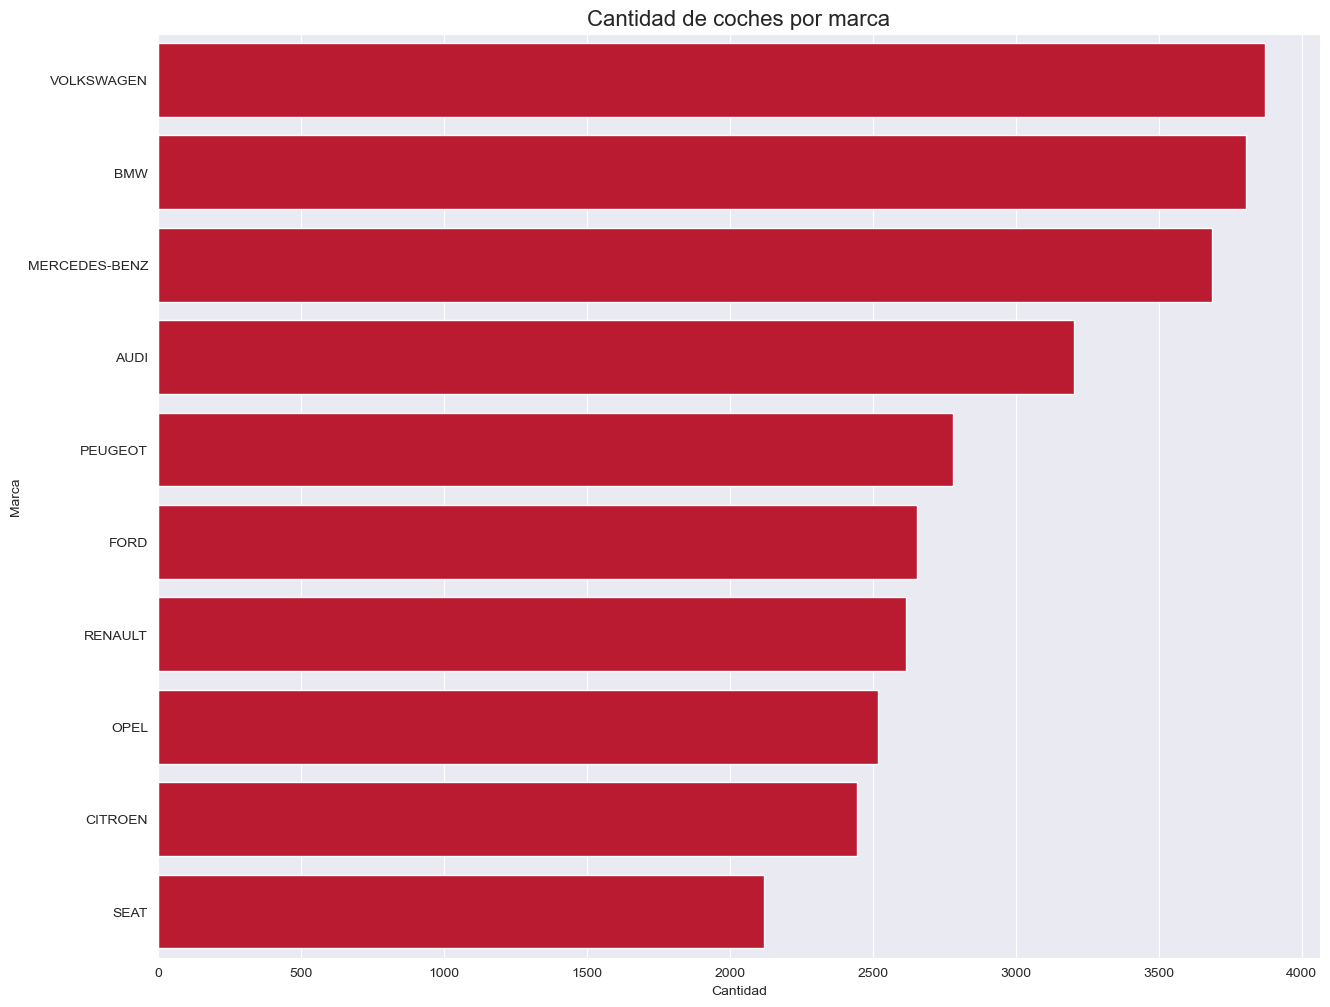

In [23]:
plt.figure(figsize = (15, 12))
sns.countplot(y = marca_df, order=marca_df.value_counts(ascending=False).index, color=colors[0])

plt.title("Cantidad de coches por marca", fontsize=16)
plt.xlabel("Cantidad")
plt.ylabel("Marca")

plt.show()

En el gráfico vemos cómo tenemos muchos coches registrados en la base de datos para cada una de las 10 marcas.

Vamos a asignar un valor numérico a cada marca para poder utilizar dicha columna como feature del modelo:

In [24]:
# Asignamos cada marca a un valor numérico utilizando LabelEncoder:

from sklearn.preprocessing import LabelEncoder

encoder_marca = LabelEncoder()
encoder_marca.fit(df["marca"].sort_values(ascending=False))
list(encoder_marca.classes_)
df["marca"] = encoder_marca.transform(df["marca"])

# Guardamos el LabelEncoder para poder utilizarlo después en otros archivos:

with open('../include/utils/label_encoder_marca.pkl', 'wb') as archivo_salida1:
    pickle.dump(encoder_marca, archivo_salida1)

df["marca"].value_counts()

marca
9    3871
1    3806
4    3685
0    3205
6    2780
3    2653
7    2615
5    2519
2    2444
8    2121
Name: count, dtype: int64

In [25]:
# muestra las marcas originales

print(encoder_marca.classes_) 


['AUDI' 'BMW' 'CITROEN' 'FORD' 'MERCEDES-BENZ' 'OPEL' 'PEUGEOT' 'RENAULT'
 'SEAT' 'VOLKSWAGEN']


In [26]:
# Para visualizar el mapping de marca con LabelEncoder

list(encoder_marca.inverse_transform([0]))

['AUDI']

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 0 to 36606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29699 non-null  int32  
 1   modelo          29699 non-null  object 
 2   precio          29699 non-null  float64
 3   combustible     29699 non-null  object 
 4   anyo_vehiculo   29699 non-null  float64
 5   kilometraje     29699 non-null  int64  
 6   potencia        29699 non-null  float64
 7   num_puertas     29699 non-null  float64
 8   tipo_cambio     29699 non-null  object 
 9   origen_anuncio  29699 non-null  object 
dtypes: float64(4), int32(1), int64(1), object(4)
memory usage: 2.4+ MB


Vamos ahora con la columna ```"modelo"```:

In [28]:
df["modelo"].value_counts()

modelo
golf            1224
serie 3          984
a3               752
clase c          738
a4               725
                ... 
400                1
iX1 xDrive30       1
ID. BUZZ Pro       1
140d               1
r21                1
Name: count, Length: 373, dtype: int64

Tenemos 373 modelos diferentes. En esta ocasión no realizamos el countplot ya que es información demasiado específica para visualizar.

Aunque son muchos valores diferentes, por el momento, realizamos otro Label Encoder. Más adelante veremos si es una columna que aporte información al modelo.

In [29]:
from sklearn.preprocessing import LabelEncoder

encoder_modelo = LabelEncoder()
encoder_modelo.fit(df["modelo"].sort_values(ascending=False))
list(encoder_modelo.classes_)
df["modelo"] = encoder_modelo.transform(df["modelo"])

# Guardamos el Encoding:

with open('../include/utils/label_encoder_modelo.pkl', 'wb') as archivo_salida2:
    pickle.dump(encoder_modelo, archivo_salida2)

df["modelo"].value_counts()

modelo
196    1224
309     984
53      752
119     738
54      725
       ... 
31        1
215       1
48        1
6         1
279       1
Name: count, Length: 373, dtype: int64

In [30]:
# Para visualizar el mapping de model con LabelEncoder

list(encoder_modelo.inverse_transform([196]))

['golf']

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 0 to 36606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29699 non-null  int32  
 1   modelo          29699 non-null  int32  
 2   precio          29699 non-null  float64
 3   combustible     29699 non-null  object 
 4   anyo_vehiculo   29699 non-null  float64
 5   kilometraje     29699 non-null  int64  
 6   potencia        29699 non-null  float64
 7   num_puertas     29699 non-null  float64
 8   tipo_cambio     29699 non-null  object 
 9   origen_anuncio  29699 non-null  object 
dtypes: float64(4), int32(2), int64(1), object(3)
memory usage: 2.3+ MB


Vamos ahora con la columna ```"combustible"```:

In [32]:
df["combustible"].value_counts()

combustible
Diésel                19469
Gasolina               9280
Híbrido Enchufable      325
Eléctrico               306
Híbrido                 212
Gas natural (CNG)        58
Gas licuado (GLP)        49
Name: count, dtype: int64

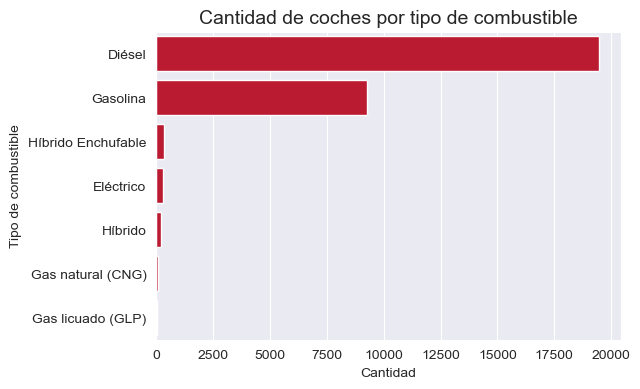

In [34]:
plt.figure(figsize = (6, 4))
sns.countplot(y = df["combustible"], order=df['combustible'].value_counts(ascending=False).index, color=colors[0])


plt.title("Cantidad de coches por tipo de combustible", fontsize=14)

plt.xlabel("Cantidad")
plt.ylabel("Tipo de combustible")

plt.show()

Vemos cómo predominan los coches de diésel y gasolina.

Convertimos los valores en numéricos utilizando un mapeado:

In [35]:
# Aplicamos un mapeado para la columna "fuel"

tipos_combutible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido Enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
df["combustible"] = df["combustible"].map(tipos_combutible)

In [36]:
df["combustible"].value_counts()

combustible
0    19469
1     9280
4      325
3      306
2      212
6       58
5       49
Name: count, dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 0 to 36606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29699 non-null  int32  
 1   modelo          29699 non-null  int32  
 2   precio          29699 non-null  float64
 3   combustible     29699 non-null  int64  
 4   anyo_vehiculo   29699 non-null  float64
 5   kilometraje     29699 non-null  int64  
 6   potencia        29699 non-null  float64
 7   num_puertas     29699 non-null  float64
 8   tipo_cambio     29699 non-null  object 
 9   origen_anuncio  29699 non-null  object 
dtypes: float64(4), int32(2), int64(2), object(2)
memory usage: 2.3+ MB


Veamos los valores de la siguiente columna no numérica, ```"num_puertas"```:

In [39]:
df["num_puertas"] = df["num_puertas"].astype(int)

df["num_puertas"].value_counts()

num_puertas
5    20996
4     5017
3     2152
2     1534
Name: count, dtype: int64

Vamos a agrupar los coches de 5 puertas con los de 4, y los de 3 con los de 2, ya que la diferencia es que no se cuenta el maletero.

In [40]:
num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
                     
df["num_puertas"] = df["num_puertas"].map(num_puertas)

In [41]:
df["num_puertas"].value_counts()

num_puertas
5    26013
3     3686
Name: count, dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 0 to 36606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29699 non-null  int32  
 1   modelo          29699 non-null  int32  
 2   precio          29699 non-null  float64
 3   combustible     29699 non-null  int64  
 4   anyo_vehiculo   29699 non-null  float64
 5   kilometraje     29699 non-null  int64  
 6   potencia        29699 non-null  float64
 7   num_puertas     29699 non-null  int64  
 8   tipo_cambio     29699 non-null  object 
 9   origen_anuncio  29699 non-null  object 
dtypes: float64(3), int32(2), int64(3), object(2)
memory usage: 2.3+ MB


De nuevo, convertimos a numérica la columna ```"tipo_cambio"```:

In [43]:
df["tipo_cambio"].value_counts()

tipo_cambio
Manual        19857
Automático     9842
Name: count, dtype: int64

In [44]:
df["tipo_cambio"] = df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

In [45]:
df["tipo_cambio"].value_counts()

tipo_cambio
0    19857
1     9842
Name: count, dtype: int64

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 0 to 36606
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   marca           29699 non-null  int32  
 1   modelo          29699 non-null  int32  
 2   precio          29699 non-null  float64
 3   combustible     29699 non-null  int64  
 4   anyo_vehiculo   29699 non-null  float64
 5   kilometraje     29699 non-null  int64  
 6   potencia        29699 non-null  float64
 7   num_puertas     29699 non-null  int64  
 8   tipo_cambio     29699 non-null  int64  
 9   origen_anuncio  29699 non-null  object 
dtypes: float64(3), int32(2), int64(4), object(1)
memory usage: 2.3+ MB


Tan solo falta la columna ```"origen_anuncio"```, que vamos a eliminar ya que sólo la hemos mantenido para diferenciar el origen del anuncio, pero no la queremos utilizar en el modelo predictivo.

In [47]:
df.drop(columns=["origen_anuncio"], inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29699 entries, 0 to 36606
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   marca          29699 non-null  int32  
 1   modelo         29699 non-null  int32  
 2   precio         29699 non-null  float64
 3   combustible    29699 non-null  int64  
 4   anyo_vehiculo  29699 non-null  float64
 5   kilometraje    29699 non-null  int64  
 6   potencia       29699 non-null  float64
 7   num_puertas    29699 non-null  int64  
 8   tipo_cambio    29699 non-null  int64  
dtypes: float64(3), int32(2), int64(4)
memory usage: 2.0 MB


Ya tenemos nuestro DataFrame con todas las columnas de tipo numérico, listas para ser utilizadas por el modelo (después de escalar, dividir los conjuntos de train y test, etc.).

Guardamos el DataFrame.

In [50]:
# Guardamos el DataFrame transformado

df.to_csv("../include/data/processed/df_pre_modelo.csv")

## 3. Modelos predictivos.

In [52]:
df = pd.read_csv("../include/data/processed/df_pre_modelo.csv", index_col=0).reset_index(drop=True)
df

,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,1,356,37900.0,2,2021.0,33200,190.0,5,1
1,6,29,9000.0,1,2016.0,127300,110.0,5,0
2,7,143,11990.0,0,2022.0,123000,100.0,5,0
3,2,92,16500.0,1,2022.0,18150,83.0,5,0
4,9,110,67900.0,0,2023.0,12000,150.0,5,1
...,...,...,...,...,...,...,...,...,...
29694,8,239,18590.0,0,2019.0,21153,115.0,5,0
29695,7,237,14500.0,0,2015.0,68750,150.0,3,0
29696,6,5,11000.0,1,2019.0,21422,72.0,5,0
29697,0,289,47900.0,1,2013.0,47900,450.0,5,1


Ya tenemos 9 columnas numéricas con las que poder predecir la columna target (```"precio"```). Vamos ahora a ver la distibución de datos de la columna target:

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

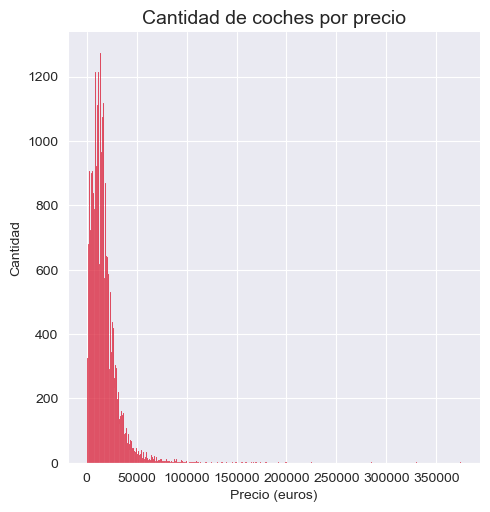

In [53]:
plt.figure(figsize=(12, 8))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio", fontsize=14)

plt.xlabel("Precio (euros)")
plt.ylabel("Cantidad")

plt.show()

Vemos que existen muchos coches con un precio más bajo, y que, para precios más elevados, se reduce el número. Para corregir esto, y aumentar la eficacia del modelo predictivo, vamos a aplicar una transformación logarítmica a la columna ```"precio"```, de modo que los datos tiendan a una distribución normal. 

Al final, cuando ya esté hecho el modelo, habrá que deshacer esta transformación para obtener el precio real del vehículo a predecir.

In [54]:
# Transformación logarítmica del target

df["precio"] = np.log(df["precio"])

c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\alberto.pintos\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

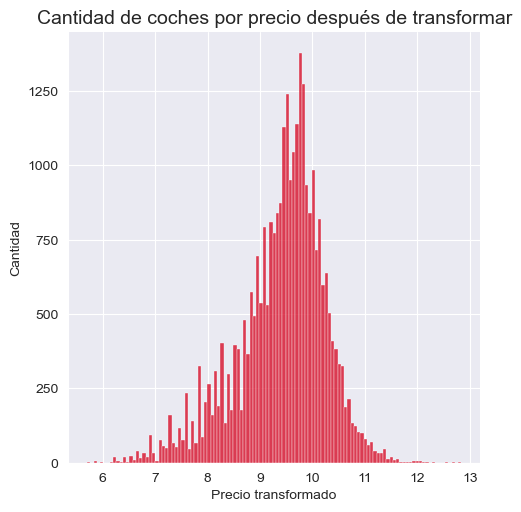

In [56]:
plt.figure(figsize=(12, 8))

sns.displot(df["precio"], color=colors[0])

plt.title("Cantidad de coches por precio después de transformar", fontsize=14)

plt.xlabel("Precio transformado")
plt.ylabel("Cantidad")

plt.yticks(range(0, 1500, 250))

plt.show()

Vemos como ahora los datos del target se distibuyen de forma gaussiana, por lo que el modelo funcionará mejor.

Vamos ahora a dividir los datos de X (features) e y (target).

In [57]:
X = df.drop("precio", axis=1)
y = df["precio"]

In [58]:
X

,marca,modelo,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,tipo_cambio
0,1,356,2,2021.0,33200,190.0,5,1
1,6,29,1,2016.0,127300,110.0,5,0
2,7,143,0,2022.0,123000,100.0,5,0
3,2,92,1,2022.0,18150,83.0,5,0
4,9,110,0,2023.0,12000,150.0,5,1
...,...,...,...,...,...,...,...,...
29694,8,239,0,2019.0,21153,115.0,5,0
29695,7,237,0,2015.0,68750,150.0,3,0
29696,6,5,1,2019.0,21422,72.0,5,0
29697,0,289,1,2013.0,47900,450.0,5,1


Vamos a realizar un heatmap de las features de nuestro modelo, para ver cómo de correlacionadas están entre ellas:

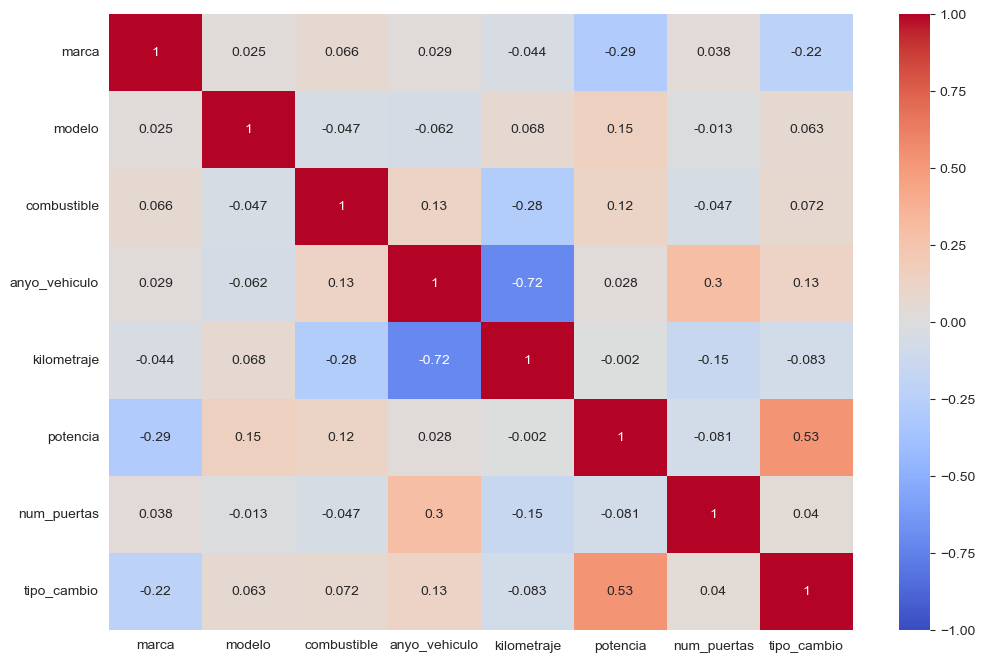

In [59]:
matriz_corr = X.corr(numeric_only=True).round(decimals=3)

plt.figure(figsize=(12, 8))

sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Vemos que la mayor correlación se da entre los kilómetros y el año del vehículo, y es negativa. Esto es lógico, ya que cuanto mayor sea el año (y más nuevp el coche), menor suele ser el número de kilómetros realizados.

Además de esto, cabe mencionar que ninguna de las correlaciones es lo suficientemente elevada como para plantearse prescindir de alguna columna.

Separamos los datos de train y test:

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23759, 8)
(5940, 8)
(23759,)
(5940,)


Vamos a escalar los datos de X entre 0 y 1:

In [61]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train)

# Guardamos el Scaler

with open('../include/utils/scaler.pkl', 'wb') as archivo_salida4:
    pickle.dump(scaler, archivo_salida4)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
X_train

array([[0.22222222, 0.24797844, 0.16666667, ..., 0.08688525, 1.        ,
        0.        ],
       [0.11111111, 0.83557951, 0.16666667, ..., 0.48688525, 0.        ,
        1.        ],
       [0.        , 0.14555256, 0.        , ..., 0.18196721, 1.        ,
        0.        ],
       ...,
       [0.88888889, 0.64420485, 0.16666667, ..., 0.14098361, 1.        ,
        0.        ],
       [0.77777778, 0.38544474, 0.        , ..., 0.07540984, 1.        ,
        0.        ],
       [0.33333333, 0.50943396, 0.16666667, ..., 0.14098361, 1.        ,
        0.        ]])

Comenzamos la seleción del modelo de regresión. Para ello, probamos varias parametrizaciones de modelos utilizando GridSearchCV.

In [ ]:
# Importamos los modelos de regresión que utilizaremos

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost

from sklearn.ensemble import VotingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn import metrics

In [66]:
# LinearRegression??

### 3.1. Linear Regression.

In [67]:
# Linear Regression

param = {}

gs_lin_reg = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_lin_reg.fit(X_train, y_train)

y_pred = gs_lin_reg.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.11461013111805038
RMSE: 0.33854118083041296
MAE: 0.23870741331869805
MAPE: 0.0261976080078374
r2 score: 0.8350559570096232


### 3.2. Polynomial Regression.

In [70]:
# Polynomial Regression

param = {}

for degree in range(1, 6):

    poly_feat = PolynomialFeatures(degree = degree)

    poly_feat.fit(X_train)

    X_train_poly = poly_feat.transform(X_train)
    X_test_poly = poly_feat.transform(X_test)


    gs_poly = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

    gs_poly.fit(X_train_poly, y_train)

    y_pred = gs_poly.predict(X_test_poly)

    print(f"Poly Degree {degree}:")

    print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
    print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
    print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

    print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")
    print(" ")

Poly Degree 1:
MSE: 0.11461013111804957
RMSE: 0.3385411808304118
MAE: 0.23870741331869574
MAPE: 0.026197608007837523
r2 score: 0.8350559570096244
 
Poly Degree 2:
MSE: 0.08969448465760148
RMSE: 0.2994903748997645
MAE: 0.20880008952004817
MAPE: 0.02296056967485811
r2 score: 0.8709139341431829
 
Poly Degree 3:
MSE: 0.07531957401464005
RMSE: 0.2744441182001175
MAE: 0.1849798011154453
MAPE: 0.02045669961142007
r2 score: 0.891601947113286
 
Poly Degree 4:
MSE: 0.07132395700256919
RMSE: 0.26706545452860275
MAE: 0.17608620688370796
MAPE: 0.019463395613474915
r2 score: 0.8973523394894474
 
Poly Degree 5:
MSE: 0.0712422159219938
RMSE: 0.2669123749884853
MAE: 0.17137233242708003
MAPE: 0.018930735957661968
r2 score: 0.897469979214461
 


In [71]:
# El mejor es el de grado 5:

degree = 5
poly_feat = PolynomialFeatures(degree = degree)

poly_feat.fit(X_train)

X_train_poly = poly_feat.transform(X_train)
X_test_poly = poly_feat.transform(X_test)


best_poly_model = GridSearchCV(estimator=LinearRegression(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

best_poly_model.fit(X_train_poly, y_train)

y_pred = best_poly_model.predict(X_test_poly)

print(f"Poly Degree {degree}:")

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

Poly Degree 5:
MSE: 0.0712422159219938
RMSE: 0.2669123749884853
MAE: 0.17137233242708003
MAPE: 0.018930735957661968
r2 score: 0.897469979214461


### 3.3. RandomForest.

In [72]:
# RandomForest

param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

gs_rf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_rf.fit(X_train, y_train)

y_pred = gs_rf.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.05245973242634091
RMSE: 0.2290408968423345
MAE: 0.1432143737308114
MAPE: 0.0159770832604703
r2 score: 0.9245012611347475


In [73]:
gs_rf.best_params_

{'max_depth': 33, 'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}

### 3.4. ADA Boost Regression.

In [74]:
# ADA

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_ada = GridSearchCV(estimator=AdaBoostRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_ada.fit(X_train, y_train)

y_pred = gs_ada.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.12913964574632744
RMSE: 0.3593600502926382
MAE: 0.2685003649807258
MAPE: 0.029238076979689855
r2 score: 0.8141454418387843


In [75]:
gs_ada.best_score_

-0.1272252746038315

In [76]:
gs_ada.best_params_

{'learning_rate': 0.4, 'n_estimators': 100, 'random_state': 42}

### 3.5. Gradient Boosting Regression.

In [77]:
# Gradient Boost

param = {"n_estimators":[50, 100, 300], "learning_rate":np.arange(0.1, 1.1, 0.1), "random_state":[42]}

gs_gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_gb.fit(X_train, y_train)

y_pred = gs_gb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04443449167430775
RMSE: 0.210794904289235
MAE: 0.14072856066304698
MAPE: 0.015624269353422865
r2 score: 0.9360509875219203


### 3.6. XGradient Boosting Regression.

In [78]:
# XG Boost

param = {}

gs_xgb = GridSearchCV(estimator=xgboost.XGBRegressor(), param_grid=param, cv=5, scoring="neg_mean_squared_error")

gs_xgb.fit(X_train, y_train)

y_pred = gs_xgb.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04557942078419423
RMSE: 0.21349337409904373
MAE: 0.13764354696548495
MAPE: 0.015311936673952017
r2 score: 0.9344032340948909


### 3.7. Voting.

In [79]:
# Voting

# param = {"estimators":[gs_lin_reg.best_estimator_, best_poly_model.best_estimator_, gs_rf.best_estimator_, gs_ada.best_estimator_, gs_gb.best_estimator_, gs_xgb.best_estimator_],
#          "n_jobs":[-1]}

gs_voting = VotingRegressor(estimators=[("lin_reg", gs_lin_reg.best_estimator_), ("rf", gs_rf.best_estimator_), ("ada", gs_ada.best_estimator_), ("gb", gs_gb.best_estimator_), ("xgb", gs_xgb.best_estimator_)],
                            n_jobs=-1,)

gs_voting.fit(X_train, y_train)

y_pred = gs_voting.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.053497701952873
RMSE: 0.23129570240900066
MAE: 0.15609829313481452
MAPE: 0.017271840387161876
r2 score: 0.9230074412731275


El Voting da peor. El modelo con mejores métricas es el Gradient Boosting Regressor, aunque el XGradient Boosting y el RandomForest también estaba cerca. 

## 4. Selección y análisis del mejor modelo.

### 4.1. Selección de modelo:

Vamos a comparar en una tabla el resultado obtenido para el MSE de test en cada modelo, ya que es la métrica que estamos utilizando, con el fin de elegir el mejor:

In [80]:
df_comp_modelos = pd.DataFrame({"Modelo":["Linear Regression", "Polynomial Regression (grado 5)", "RandomForest", "ADA Boost", "Gradient Boost", "XG Boost", "Voting"],
                                "MSE":[0.1146, 0.0712, 0.0525, 0.1291, 0.0444, 0.0456, 0.0535],
                                "MAE":[0.2387, 0.1714, 0.1432, 0.2685, 0.1407, 0.1376, 0.1561],
                                "r2 score":[0.8351, 0.8975, 0.9245, 0.8142, 0.9361, 0.9344, 0.9230]})

df_comp_modelos = df_comp_modelos.sort_values("MSE", ascending=True).reset_index(drop=True)
df_comp_modelos

,Modelo,MSE,MAE,r2 score
0,Gradient Boost,0.0444,0.1407,0.9361
1,XG Boost,0.0456,0.1376,0.9344
2,RandomForest,0.0525,0.1432,0.9245
3,Voting,0.0535,0.1561,0.9230
4,Polynomial Regression (grado 5),0.0712,0.1714,0.8975
5,Linear Regression,0.1146,0.2387,0.8351
6,ADA Boost,0.1291,0.2685,0.8142


Vemos que el mejor modelo es el Gradient Boost, aunque está muy cerca el XGBoost. Vamos a quedarnos con el XGBoost, ya que su tiempo de entrenamiento es mucho menor y los resultados muy similares, y también con el RandomForest, ya que su funcionamiento es distinto y sus resultados están bastante cerca, por lo que puede sernos útil para comparar.

Cabe destacar que el MAE representado en la tabla anterior no se corresponde con el error medio en la predicción del modelo sobre el precio del vehículo, ya que hemos aplicado una transformación logarítmica a este precio. Más adelante veremos el MAE y el MSE reales del mejor modelo, una vez aplicada la transformación inversa. 

Vamos a ver si podemos mejorar algo de estos dos modelos mirando la importancia de las columnas (features) y realizando alguna modificación. Comenzamos con el RandomForest:

In [81]:
gs_rf.best_estimator_.feature_importances_

array([0.02460727, 0.0320876 , 0.00499191, 0.57098731, 0.07337544,
       0.28391704, 0.00341773, 0.00661569])

Realizamos un dataframe con la importancia de las cada columna en el modelo RandomForest:

In [89]:
df_feat_imp_rf = pd.DataFrame(gs_rf.best_estimator_.feature_importances_, index=X.columns)
df_feat_imp_rf = df_feat_imp_rf.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp_rf

,Feature Importance
anyo_vehiculo,0.570987
potencia,0.283917
kilometraje,0.073375
modelo,0.032088
marca,0.024607
tipo_cambio,0.006616
combustible,0.004992
num_puertas,0.003418


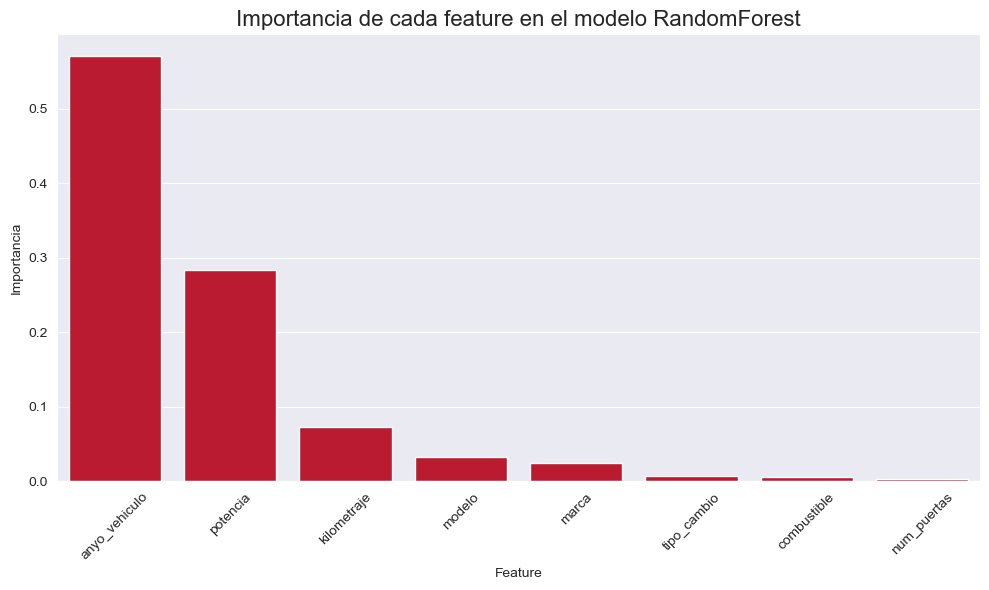

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6)) 


df_feat_imp_rf = df_feat_imp_rf.reset_index() 
df_feat_imp_rf.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp_rf, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo RandomForest", fontsize=16)
plt.xlabel("Feature")
plt.ylabel("Importancia")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observa cómo las columnas con más importancia en el precio de un coche de segunda mano son, según nuestro modelo RandomForest, el año de matriculación, potencia del motor y kms recorridos. Las columnas de modelo y marca del coche también tienen algo de importancia, y las demás (tipo de cambio, combustible y número de puertas) tienen una importancia mucho menor.

Por esto, vamos a probar a hacer un Random Forest, con la misma parametrización que el mejor de antes, pero quitando las columnas menos importantes: ```["tipo_cambio", "combustible", "num_puertas"]```, a ver si mejora el modelo.

In [91]:
# RF 2

X_rf_2 = X.drop(columns=["tipo_cambio", "combustible", "num_puertas"])
X_rf_2

,marca,modelo,anyo_vehiculo,kilometraje,potencia
0,1,356,2021.0,33200,190.0
1,6,29,2016.0,127300,110.0
2,7,143,2022.0,123000,100.0
3,2,92,2022.0,18150,83.0
4,9,110,2023.0,12000,150.0
...,...,...,...,...,...
29694,8,239,2019.0,21153,115.0
29695,7,237,2015.0,68750,150.0
29696,6,5,2019.0,21422,72.0
29697,0,289,2013.0,47900,450.0


In [92]:
from sklearn.model_selection import train_test_split

X_train_rf2, X_test_rf2, y_train_rf2, y_test_rf2 = train_test_split(X_rf_2, y, test_size=0.2, random_state=42)

print(X_train_rf2.shape)
print(X_test_rf2.shape)
print(y_train_rf2.shape)
print(y_test_rf2.shape)

(23759, 5)
(5940, 5)
(23759,)
(5940,)


In [93]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train_rf2)
X_train_rf2 = scaler.transform(X_train_rf2)
X_test_rf2 = scaler.transform(X_test_rf2)

In [94]:
# RandomForest

# param = {"n_estimators":[50, 100, 300], "max_depth":[3, 5, 9, 15, 33], "n_jobs":[-1], "random_state":[42]}

rf2 = RandomForestRegressor(n_estimators=300, max_depth=33, n_jobs=-1, random_state=42)

rf2.fit(X_train_rf2, y_train_rf2)

y_pred_rf2 = rf2.predict(X_test_rf2)

print(f"MSE: {metrics.mean_squared_error(y_test_rf2, y_pred_rf2)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_rf2, y_pred_rf2))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_rf2, y_pred_rf2)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_rf2, y_pred_rf2)}")

print(f"r2 score: {metrics.r2_score(y_test_rf2, y_pred_rf2)}")

MSE: 0.055758710357681825
RMSE: 0.23613282354997117
MAE: 0.14799043130934064
MAPE: 0.016508326874130987
r2 score: 0.9197534543534175


### 4.2. Análisis del modelo definitivo:

Obtenemos un MSE más elevado que antes, por lo que no mejora. Nos quedamos entonces el XG Boost, que era el segundo modelo con el MSE más bajo pero más rápido que el primero. Vamos a ver la importancia de las features en este modelo:

In [95]:
xgb_model = xgboost.XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(f"MSE: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test, y_pred)}")

print(f"r2 score: {metrics.r2_score(y_test, y_pred)}")

MSE: 0.04557942078419423
RMSE: 0.21349337409904373
MAE: 0.13764354696548495
MAPE: 0.015311936673952017
r2 score: 0.9344032340948909


In [96]:
X.columns

Index(['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje',
       'potencia', 'num_puertas', 'tipo_cambio'],
      dtype='object')

In [97]:
xgb_model.feature_importances_

array([0.05145216, 0.02008888, 0.01958242, 0.44428998, 0.03746107,
       0.21881962, 0.01699274, 0.19131315], dtype=float32)

In [100]:
df_feat_imp = pd.DataFrame(xgb_model.feature_importances_, index=X.columns)
df_feat_imp = df_feat_imp.rename(columns={0:"Feature Importance"}).sort_values("Feature Importance", ascending=False)
df_feat_imp

,Feature Importance
anyo_vehiculo,0.444290
potencia,0.218820
tipo_cambio,0.191313
marca,0.051452
kilometraje,0.037461
modelo,0.020089
combustible,0.019582
num_puertas,0.016993


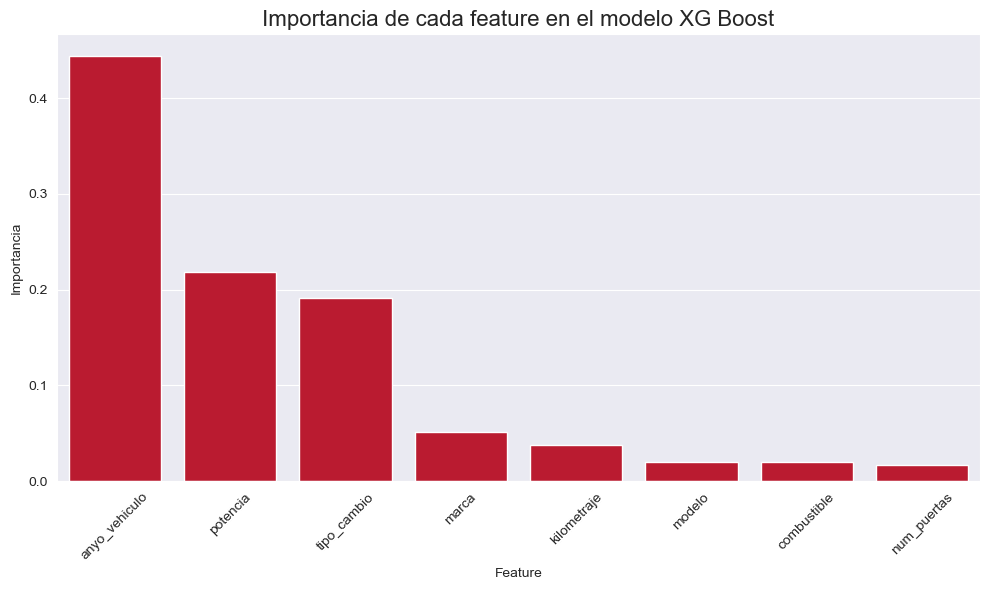

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

df_feat_imp = df_feat_imp.reset_index()
df_feat_imp.rename(columns={'index': 'Feature'}, inplace=True)

sns.barplot(data=df_feat_imp, x='Feature', y='Feature Importance', color=colors[0])

plt.title("Importancia de cada feature en el modelo XG Boost", fontsize=16)
plt.xlabel("Feature")
plt.ylabel("Importancia")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Ahora observamos que las columnas más importantes siguen siendo ```"anyo_vehiculo"``` y ```"potencia"```. Sin embargo, el XGBoost le da mucha más importancia a la columna ```"tipo_cambio"``` que el RandomForest previo, y menos a la columna ```"kilometraje"```. Además la importancia de las columnas menos importantes es más elevada que en el anterior modelo, por lo que no descartaremos ninguna de estas columnas.

Vamos a deshacer la transformación que realizamos en la columna ```"precio"``` (target) para ver la dimensión real de nuestras métricas:

In [104]:
y_pred = xgb_model.predict(X_test)

# Deshacemos la transformación logarítmica:
y_test_final = np.exp(y_test)
y_pred_final = np.exp(y_pred)

# Claculamos las métricas reales:
print(f"MSE: {metrics.mean_squared_error(y_test_final, y_pred_final)}")
print(f"RMSE: {np.sqrt(metrics.mean_squared_error(y_test_final, y_pred_final))}")
print(f"MAE: {metrics.mean_absolute_error(y_test_final, y_pred_final)}")
print(f"MAPE: {metrics.mean_absolute_percentage_error(y_test_final, y_pred_final)}")

print(f"r2 score: {metrics.r2_score(y_test_final, y_pred_final)}")

MSE: 14256628.19307195
RMSE: 3775.7950411895968
MAE: 1872.9885921902128
MAPE: 0.1405485106362972
r2 score: 0.9315665938523535


Vemos que el MAE = 1873 euros. Esto significa que para cada vehículo nos podemos ir esa cantidad de dinero de media en la predicción. 

El RMSE es algo mayor, 3776 euros, lo cual se debe a que existen unos pocos coches cuyo error es alto, y al hacer el error cuadrático este error se hace más grande.

En cuanto al MAPE, nos indica que nuestro modelo tiene un % de error medio del 14.05% sobre el precio del vehículo, el cual es algo elevado.

Vamos a exportar el modelo final:

In [107]:
import pickle

# Guardamos el modelo final:

with open("../include/model/modelo_final.pkl", 'wb') as archivo_salida:
    pickle.dump(xgb_model, archivo_salida)


Creamos una función que nos permita meter nuevos inputs en el formato de nuestro DataFrame inicial y extraer las variables para pasar directamente al modelo.

Además, creamos otras dos funciones: una para realizar predicciones y otra para destransformar la columna target ```"precio"```.

In [120]:
# Función para transformar un df con nuevos inputs de la base de datos en X, y para pasar al modelo.

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import pickle



def new_input_clean(input_df):
    '''
    Introduce los nuevos inputs en formato DataFrame con las columnas iniciales y devuelve los datos listos para introducirlos al modelo.

    El input DataFrame debe contener al menos las columnas (['marca', 'modelo', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 
    'num_puertas', 'tipo_cambio'])
    '''

    excepciones = ['marca', 'modelo', 'precio', 'combustible', 'anyo_vehiculo', 'kilometraje', 'potencia', 'num_puertas', 'tipo_cambio']

    # Reemplazar NaN con 0 excepto en las columnas de excepciones (las que utiliza el modelo)
    input_df = input_df.fillna({col: 0 for col in input_df.columns if col not in excepciones})


    input_df = input_df[excepciones]
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "potencia"].isna() == True, :]).index)
    input_df = input_df.drop(index=(input_df.loc[df.loc[:, "tipo_cambio"].isna() == True, :]).index)
    input_df = input_df.dropna()

    # Importamos los encodings hechos antes:
    encoder_marca = pickle.load(open("../include/utils/label_encoder_marca.pkl", 'rb'))
    encoder_modelo = pickle.load(open("../include/utils/label_encoder_modelo.pkl", 'rb'))

    list(encoder_marca.classes_)
    input_df["marca"] = encoder_marca.transform(input_df["marca"])

    list(encoder_modelo.classes_)
    input_df["modelo"] = encoder_modelo.transform(input_df["modelo"])

    tipos_combustible = {"Diésel" : 0,
            "Gasolina" : 1,
            "Híbrido" : 2,
            "Eléctrico" : 3,
            "Híbrido enchufable" : 4, 
            "Gas licuado (GLP)" : 5,
            "Gas natural (CNG)" : 6}
                     
    input_df["combustible"] = input_df["combustible"].map(tipos_combustible)

    num_puertas = {5: 5,
            4 : 5,
            3 : 3,
            2 : 3}
    
    input_df["num_puertas"] = input_df["num_puertas"].map(num_puertas)
    
    input_df["tipo_cambio"] = input_df["tipo_cambio"].apply(lambda x: 0 if x == "Manual" else 1)

    input_df["precio"] = np.log(input_df["precio"])

    X_input = input_df.drop("precio", axis=1)
    y_input = input_df["precio"]
    

    scaler = pickle.load(open("../include/utils/scaler.pkl", 'rb'))

    X_input = scaler.transform(X_input)

    return [X_input, y_input]

# Función para hacer predicciones

def predict(loaded_model, X_input):
    return loaded_model.predict(X_input)

# Función para deshacer la transformación y devolver el precio:

import numpy as np

def destransformar_y(y_out):
    return np.exp(y_out)

Vamos ahora a cargar el modelo y probarlo con un DataFrame de prueba con coches, para ver el precio que predice. 

In [121]:
import pickle

loaded_model = pickle.load(open("../include/model/modelo_final.pkl", 'rb'))

In [122]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [123]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
--where
--fecha_carga > '2025-05-11 22:33:00'
order by
    fecha_carga desc
;
"""

# Leemos los resultados en un DataFrame de pandas
df = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):
df_prueba = df.head()

df_prueba

,pk_anuncio_id,marca,modelo,precio,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,num_plazas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60498281,BMW,x3,37900.0,Híbrido,2021.0,33200,190.0,5.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
1,59710104,PEUGEOT,308,9000.0,Gasolina,2016.0,127300,110.0,5.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
2,60479478,RENAULT,clio,11990.0,Diésel,2022.0,123000,100.0,5.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...
3,60374025,CITROEN,c3,16500.0,Gasolina,2022.0,18150,83.0,5.0,5.0,...,Berlina,1199.0,blanco,Madrid,None,WebScraping,2025-04-19,202504.0,2025-05-18 10:05:00,https://www.coches.net/citroen-c3-puretech-60k...
4,60576644,VOLKSWAGEN,california,67900.0,Diesel,2023.0,12000,150.0,4.0,4.0,...,Monovolumen,1968.0,Blanco,Las Palmas,None,WebScraping,2025-05-18,202505.0,2025-05-18 07:24:21,https://www.coches.net/volkswagen-california-o...


In [124]:
X_input, y_input = new_input_clean(input_df=df_prueba)

In [125]:
predictions = loaded_model.predict(X_input)
predictions

array([10.6165085,  9.09715  ,  9.384863 ,  9.533099 , 10.874894 ],
      dtype=float32)

In [126]:
y_prueba = destransformar_y(predictions).round(0)
y_prueba

array([40803.,  8930., 11907., 13809., 52833.], dtype=float32)

Insertamos las predicciones realizadas en la columna ```"precio_predicho"```, al lado de la columna target ```"precio"```:

In [130]:
df_prueba.insert(4, "precio_predicho", y_prueba)
df_prueba.to_csv("../include/data/processed/df_prueba_pred.csv")
df_prueba

,pk_anuncio_id,marca,modelo,precio,precio_predicho,combustible,anyo_vehiculo,kilometraje,potencia,num_puertas,...,tipo_vehiculo,cilindrada_motor,color,provincia,etiqueta_eco,origen_anuncio,fecha_publicacion,anyomes_publicacion,fecha_carga,url
0,60498281,BMW,x3,37900.0,40803.0,Híbrido,2021.0,33200,190.0,5.0,...,SUV,1995.0,gris,Madrid,ECO (azul/verde),WebScraping,2025-05-07,202505.0,2025-05-18 14:21:01,https://www.coches.net/bmw-x3-xdrive20d-xline-...
1,59710104,PEUGEOT,308,9000.0,8930.0,Gasolina,2016.0,127300,110.0,5.0,...,Berlina,1199.0,blanco,Asturias,None,WebScraping,2025-01-25,202501.0,2025-05-18 11:18:51,https://www.coches.net/peugeot-308-5p-allure-1...
2,60479478,RENAULT,clio,11990.0,11907.0,Diésel,2022.0,123000,100.0,5.0,...,Berlina,1461.0,blanco,Málaga,None,WebScraping,2025-05-18,202505.0,2025-05-18 10:06:26,https://www.coches.net/renault-clio-equilibre-...
3,60374025,CITROEN,c3,16500.0,13809.0,Gasolina,2022.0,18150,83.0,5.0,...,Berlina,1199.0,blanco,Madrid,None,WebScraping,2025-04-19,202504.0,2025-05-18 10:05:00,https://www.coches.net/citroen-c3-puretech-60k...
4,60576644,VOLKSWAGEN,california,67900.0,52833.0,Diesel,2023.0,12000,150.0,4.0,...,Monovolumen,1968.0,Blanco,Las Palmas,None,WebScraping,2025-05-18,202505.0,2025-05-18 07:24:21,https://www.coches.net/volkswagen-california-o...


Vemos que los precios que predice el modelo se ajustan bastante a los reales. Para el vehículo VolksWagen California no lo predice bien, lo cual es más común que pase para vehículos fuera del rango de precio entre 5.000 y 25.000 euros, que era donde más cantidad había.

Registros de VolksWagen California:

In [133]:
import pandas as pd
import sqlite3

# Conexión a la BBDD:
con = sqlite3.connect("../include/db_vehiculos.db")

# Vamos a ver qué nos devuelve un select sobre la tabla:
query = """
SELECT * FROM TX_VEHICULOS_SEG_MANO
where
    marca = 'VOLKSWAGEN'
    and modelo = 'california'
;
"""

# Leemos los resultados en un DataFrame de pandas
df_vw_california = pd.read_sql_query(query, con)

# Mostramos los primeros registros (aún no hay):

# df_vw_california